# F1Ops Route Estimation

This notebook demonstrates route estimation between European F1 circuits using the Haversine formula.

**Version**: 0.1 (Feb 2020)
**Method**: Great-circle distance calculation

In [1]:
import sys
sys.path.insert(0, '../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from f1ops.data_loader import get_european_races
from f1ops.geo import calculate_leg_distance, build_season_legs

%matplotlib inline
sns.set_style('whitegrid')

## 1. Haversine Distance Formula

The Haversine formula calculates the great-circle distance between two points on a sphere given their longitudes and latitudes:

$$
a = \sin^2\left(\frac{\Delta\phi}{2}\right) + \cos(\phi_1) \cdot \cos(\phi_2) \cdot \sin^2\left(\frac{\Delta\lambda}{2}\right)
$$

$$
c = 2 \cdot \arctan2\left(\sqrt{a}, \sqrt{1-a}\right)
$$

$$
d = R \cdot c
$$

Where:
- φ is latitude, λ is longitude
- R is Earth's radius (≈6371 km)

## 2. Load 2019 Season Races

In [2]:
races_2019 = get_european_races(2019)
print(f"Loaded {len(races_2019)} European races for 2019\n")

# Display race sequence
for race in races_2019:
    print(f"Round {race.round:2d}: {race.race_name:30s} | {race.circuit.city:15s}, {race.circuit.country}")

Loaded 8 European races for 2019

Round  5: Spanish Grand Prix             | Montmeló       , Spain
Round  6: Monaco Grand Prix              | Monte Carlo    , Monaco
Round  8: French Grand Prix              | Le Castellet   , France
Round  9: Austrian Grand Prix            | Spielberg      , Austria
Round 11: German Grand Prix              | Hockenheim     , Germany
Round 12: Hungarian Grand Prix           | Budapest       , Hungary
Round 13: Belgian Grand Prix             | Spa            , Belgium
Round 14: Italian Grand Prix             | Monza          , Italy


## 3. Calculate Legs Between Consecutive Races

In [3]:
legs = build_season_legs(races_2019)

print(f"Total legs: {len(legs)}\n")
print(f"{'Leg':<5} {'From → To':<45} {'Distance (km)':<15}")
print("-" * 65)

for idx, leg in enumerate(legs):
    print(f"{idx+1:<5} {leg.leg_name:<45} {leg.distance_km:>10.2f}")

Total legs: 7

Leg   From → To                                     Distance (km)  
-----------------------------------------------------------------
1     Montmeló → Monte Carlo                            486.50
2     Monte Carlo → Le Castellet                        142.29
3     Le Castellet → Spielberg                          830.48
4     Spielberg → Hockenheim                            516.20
5     Hockenheim → Budapest                             813.11
6     Budapest → Spa                                   1020.44
7     Spa → Monza                                       589.58


## 4. Distance Distribution Analysis

In [4]:
distances = [leg.distance_km for leg in legs]

# Summary statistics
print("Distance Statistics (km):")
print(f"  Total:   {sum(distances):>10.2f}")
print(f"  Mean:    {np.mean(distances):>10.2f}")
print(f"  Median:  {np.median(distances):>10.2f}")
print(f"  Std Dev: {np.std(distances):>10.2f}")
print(f"  Min:     {min(distances):>10.2f}")
print(f"  Max:     {max(distances):>10.2f}")

Distance Statistics (km):
  Total:      4398.60
  Mean:        628.37
  Median:      589.58
  Std Dev:     267.04
  Min:         142.29
  Max:        1020.44


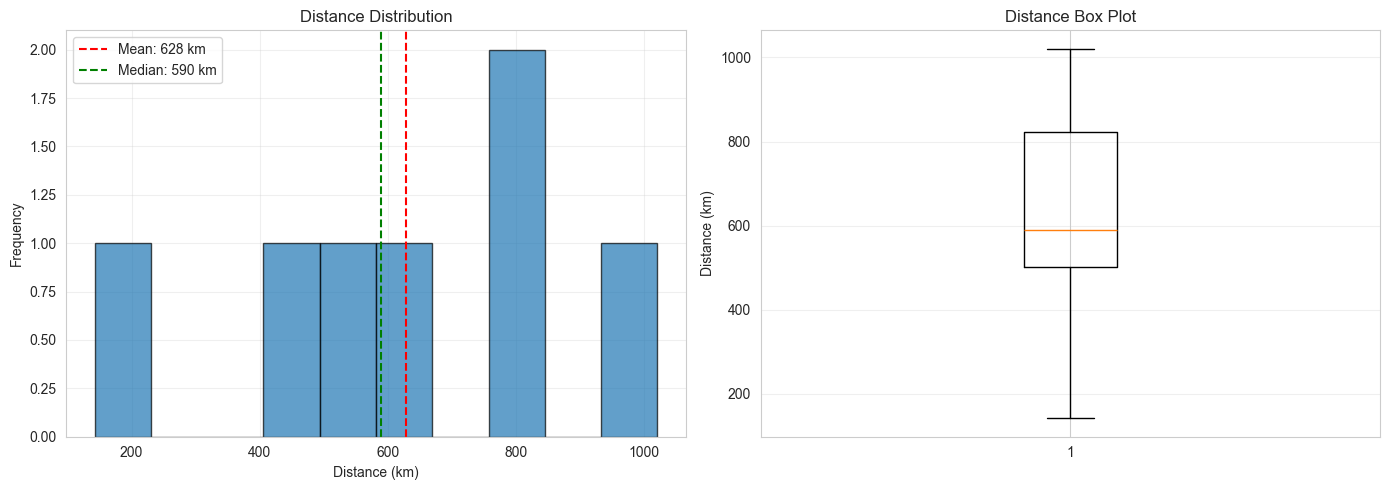

In [5]:
# Distribution plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(distances, bins=10, edgecolor='black', alpha=0.7)
axes[0].axvline(np.mean(distances), color='red', linestyle='--', label=f'Mean: {np.mean(distances):.0f} km')
axes[0].axvline(np.median(distances), color='green', linestyle='--', label=f'Median: {np.median(distances):.0f} km')
axes[0].set_xlabel('Distance (km)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distance Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(distances, vert=True)
axes[1].set_ylabel('Distance (km)')
axes[1].set_title('Distance Box Plot')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 5. Longest and Shortest Legs

In [6]:
# Sort by distance
sorted_legs = sorted(legs, key=lambda x: x.distance_km, reverse=True)

print("Top 5 Longest Legs:")
for idx, leg in enumerate(sorted_legs[:5], 1):
    print(f"  {idx}. {leg.leg_name:<45} {leg.distance_km:>10.2f} km")

print("\nTop 5 Shortest Legs:")
for idx, leg in enumerate(reversed(sorted_legs[-5:]), 1):
    print(f"  {idx}. {leg.leg_name:<45} {leg.distance_km:>10.2f} km")

Top 5 Longest Legs:
  1. Budapest → Spa                                   1020.44 km
  2. Le Castellet → Spielberg                          830.48 km
  3. Hockenheim → Budapest                             813.11 km
  4. Spa → Monza                                       589.58 km
  5. Spielberg → Hockenheim                            516.20 km

Top 5 Shortest Legs:
  1. Monte Carlo → Le Castellet                        142.29 km
  2. Montmeló → Monte Carlo                            486.50 km
  3. Spielberg → Hockenheim                            516.20 km
  4. Spa → Monza                                       589.58 km
  5. Hockenheim → Budapest                             813.11 km


## 6. Cumulative Distance Through Season

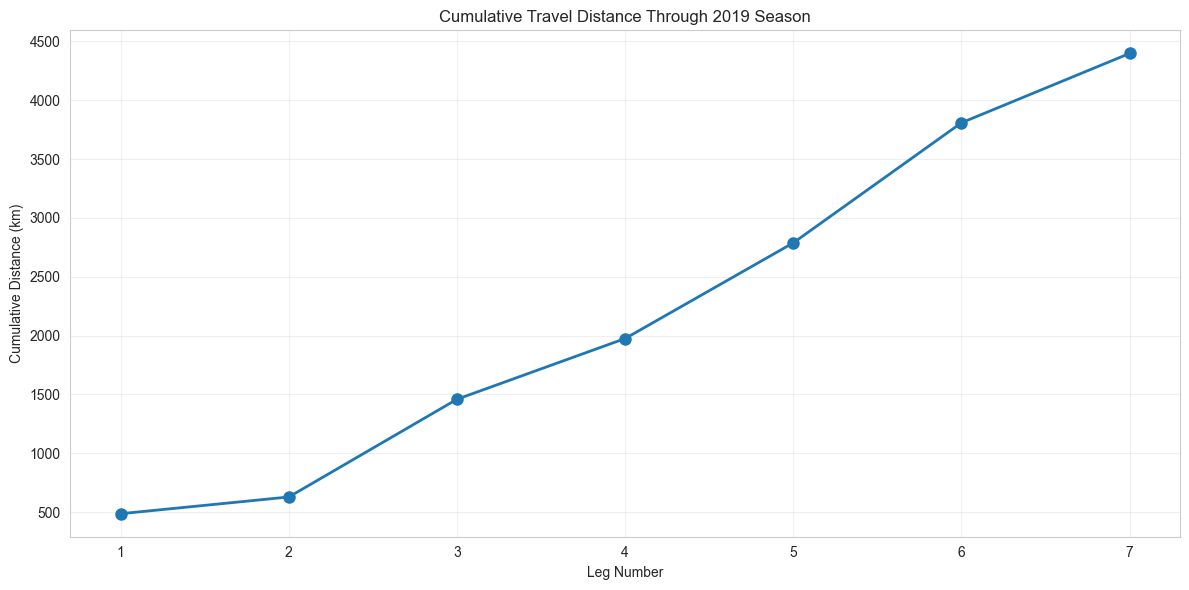

Total season travel distance: 4,399 km


In [7]:
cumulative = np.cumsum([leg.distance_km for leg in legs])

plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cumulative) + 1), cumulative, marker='o', linewidth=2, markersize=8)
plt.xlabel('Leg Number')
plt.ylabel('Cumulative Distance (km)')
plt.title('Cumulative Travel Distance Through 2019 Season')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total season travel distance: {cumulative[-1]:,.0f} km")

## 7. Haversine vs Road Distance

The Haversine formula provides a lower bound (straight-line distance). Actual road distances are typically 20-40% longer due to:
- Road network topology
- Geographic barriers (mountains, water)
- Border crossings
- Routing efficiency

In [8]:
# Apply estimated road distance multiplier
road_multiplier = 1.3  # Conservative estimate

haversine_total = sum(distances)
estimated_road_total = haversine_total * road_multiplier

print(f"Haversine (straight-line) total: {haversine_total:>10,.0f} km")
print(f"Estimated road distance total:   {estimated_road_total:>10,.0f} km")
print(f"Difference:                      {estimated_road_total - haversine_total:>10,.0f} km ({(road_multiplier-1)*100:.0f}%)")

Haversine (straight-line) total:      4,399 km
Estimated road distance total:        5,718 km
Difference:                           1,320 km (30%)


## Summary

This notebook demonstrated:
- Haversine distance calculations between F1 circuits
- Distance distribution analysis for 2019 season
- Identification of longest/shortest legs
- Limitations of great-circle distance vs actual road routing

**Next**: Cost and emissions modeling based on these distances